In [39]:
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPRegressor
import optuna
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from scipy.special import expit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, Normalizer
import shap
import scipy.stats as stats

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\vodka.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
x = df.drop(columns=['quality'])
y = df['quality']

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=42, stratify=y)

In [12]:
pipeline_random = Pipeline([
    ('scaler', Normalizer()),
    ('mlp',MLPRegressor(random_state=42, max_iter=100))
])

In [13]:
param_dist = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 50)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__solver": ["adam", "sgd"],
    "mlp__alpha": [0.0001, 0.001, 0.01],
    "mlp__learning_rate": ["constant", "adaptive"],
}


random_search = RandomizedSearchCV(pipeline_random, param_dist, cv=5, n_jobs=-1, verbose=1)
random_search.fit(x_train, y_train)

print("Best parameters (RandomizedSearchCV):", random_search.best_params_)
best_model_random = random_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters (RandomizedSearchCV): {'mlp__solver': 'adam', 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (100, 50), 'mlp__alpha': 0.01, 'mlp__activation': 'tanh'}


c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
y_pred_random = best_model_random.predict(x_test)
mse_random = mean_squared_error(y_test, y_pred_random)
print("Test Accuracy (RandomizedSearchCV):", mse_random)

Test Accuracy (RandomizedSearchCV): 0.6210762449950066


In [15]:
def objective(trial):
    hidden_layer_sizes = tuple(trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)]))
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    alpha = trial.suggest_float("alpha", 1e-4, 1e-2, log=True)
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "adaptive"])

    pipeline_bayes = Pipeline([
        ('scaler',Normalizer()),
        ('mlp',MLPRegressor(random_state=42, max_iter=100, hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver,
                             alpha=alpha, learning_rate=learning_rate))
    ])
    pipeline_bayes.fit(x_train, y_train)
    y_pred = pipeline_bayes.predict(x_test)
    return mean_squared_error(y_test, y_pred)

In [16]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, n_jobs=-1)

[I 2025-02-15 03:30:52,797] A new study created in memory with name: no-name-61b48ed2-30a3-401c-8a25-7482bfb2cba5
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50, 50) which is of type tuple.
  warnings.warn(

In [18]:
print("Best parameters (Optuna):", study.best_params)
best_param=study.best_params
best_model = Pipeline([
    ('scaler',Normalizer()),
    ('mlp',MLPRegressor(**best_param, max_iter=100, random_state=42))
])
best_model.fit(x_train, y_train)

Best parameters (Optuna): {'hidden_layer_sizes': (50,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0007383646117740584, 'learning_rate': 'constant'}


c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('scaler', Normalizer()),
                ('mlp',
                 MLPRegressor(alpha=0.0007383646117740584,
                              hidden_layer_sizes=(50,), max_iter=100,
                              random_state=42))])

In [19]:
y_pred = best_model.predict(x_test)
print(y_pred)

[6.08050059 5.69078668 5.98498945 5.64882947 5.98628976 5.98939545
 5.9194951  5.59694116 5.64882947 5.4392879  5.15495387 5.97846018
 5.54559028 5.9919433  5.8648462  5.72035436 5.69174349 5.53822687
 5.92691533 5.37092883 5.23251733 5.96555656 5.9008953  5.94539661
 6.0955116  5.87652346 5.19077638 5.73951384 4.97353665 6.15783532
 6.08892233 5.1635303  5.67008394 5.80060636 5.58345172 5.77649769
 5.42920606 5.85172182 5.6270972  5.05411945 4.97416314 6.02494712
 5.43505904 5.68287108 6.08643867 5.70559041 5.89409443 5.50644795
 5.54907635 4.95192029 5.6529852  5.78480462 5.61402287 5.82298883
 5.88747886 5.80448525 5.14575713 5.93233685 5.00656978 5.98562962
 5.72035436 5.35360828 5.22630346 5.41508341 5.55897915 5.51064469
 6.00649293 5.91541376 6.12709894 5.7947912  5.56577748 5.82765781
 5.01739266 5.5384004  4.85347888 5.60519728 5.88815595 6.15939508
 6.01172092 5.35360828 5.71237483 5.90969961 6.00128594 5.5384004
 5.59303918 5.00780081 5.48720386 5.86470966 5.99614548 5.87756

In [21]:
proba = expit(y_pred)
print(proba)

[0.99771819 0.99663443 0.99749008 0.99649072 0.99749333 0.99750108
 0.99732064 0.99630452 0.99649072 0.9956762  0.99426236 0.99747368
 0.99611055 0.99750743 0.99717057 0.99673216 0.99663764 0.99608192
 0.9973404  0.99537171 0.9946883  0.99744095 0.99727048 0.99738897
 0.99775211 0.99720332 0.99446314 0.99679398 0.9931289  0.99788764
 0.99773728 0.99431108 0.99656427 0.99698341 0.99625452 0.99691003
 0.99563258 0.9971333  0.9964139  0.9936575  0.99313318 0.99758815
 0.99565796 0.99660777 0.99773167 0.99668372 0.9972519  0.99595592
 0.99612403 0.99297981 0.99650522 0.99693551 0.99636688 0.99704998
 0.99723371 0.99699505 0.99420966 0.99735474 0.99335068 0.99749168
 0.99673216 0.99529123 0.99465537 0.99557074 0.99616208 0.99597278
 0.99754334 0.99730971 0.99782185 0.99696587 0.99618798 0.99706368
 0.99342179 0.99608259 0.9922592  0.99633479 0.99723558 0.99789093
 0.99755612 0.99529123 0.99670607 0.99729434 0.99753055 0.99608259
 0.99629012 0.99335881 0.99587766 0.99717018 0.99751785 0.9972

In [23]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\vodkapredict.csv")
prediksi.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,8.6,0.38,0.36,3.0,0.081,30.0,119.0,0.9970,3.20,0.56,9.4
1,7.6,0.51,0.15,2.8,0.110,33.0,73.0,0.9955,3.17,0.63,10.2
2,7.7,0.62,0.04,3.8,0.084,25.0,45.0,0.9978,3.34,0.53,9.5
3,10.2,0.42,0.57,3.4,0.070,4.0,10.0,0.9971,3.04,0.63,9.6
4,7.5,0.63,0.12,5.1,0.111,50.0,110.0,0.9983,3.26,0.77,9.4


In [24]:
y_prediksi = best_model.predict(prediksi)
probabilitas_prediksi = expit(y_prediksi)
print(y_prediksi)
print(probabilitas_prediksi)

[5.0452296  5.41952798 5.68209626 5.96419578 5.29398304 5.41564969]
[0.99360123 0.99559029 0.99660515 0.99743747 0.99500337 0.99557324]


In [25]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

n = len(y_test)
p = x_test.shape[1]
r2_adj = 1 - ((1-r2) * (n - 1) / (n - p - 1))

print(mse)
print(mae)
print(rmse)
print(r2)
print(r2_adj)

0.6866740607234586
0.6265157101138444
0.8286579877871562
-0.044310418046578315
-0.0652728534453233


In [26]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Cross-Validation Scores: [-0.68077956 -0.50883743 -0.67008373 -0.67071129 -0.69794529]
Mean CV Accuracy: -0.6456714591369399


c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


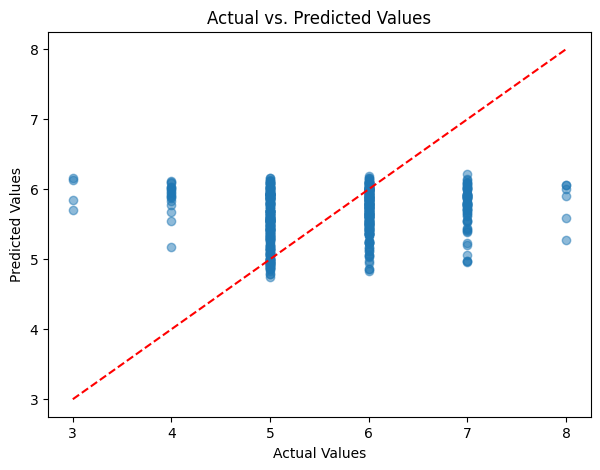

In [27]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

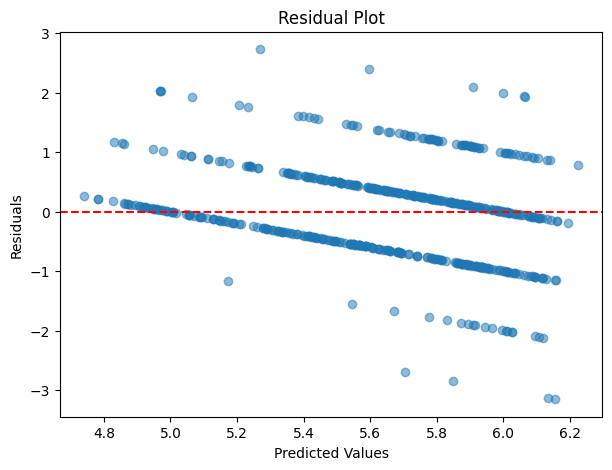

In [28]:
residuals = y_test - y_pred

plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

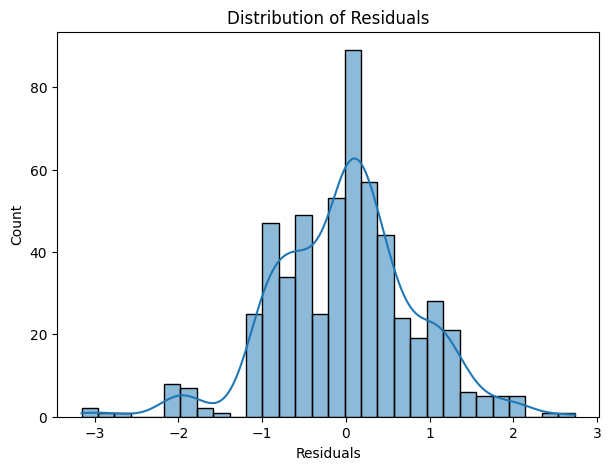

In [29]:
plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

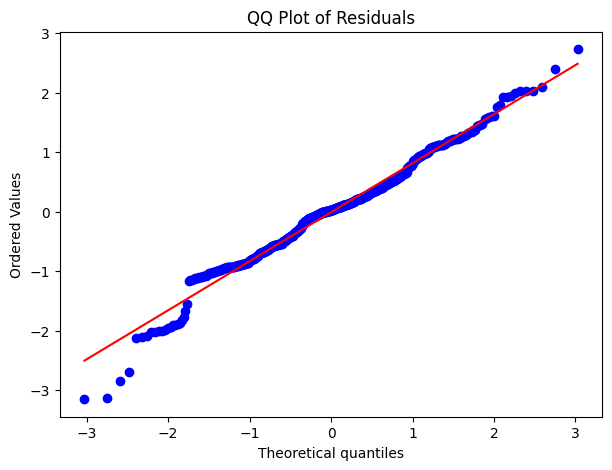

In [36]:
plt.figure(figsize=(7, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Robyi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

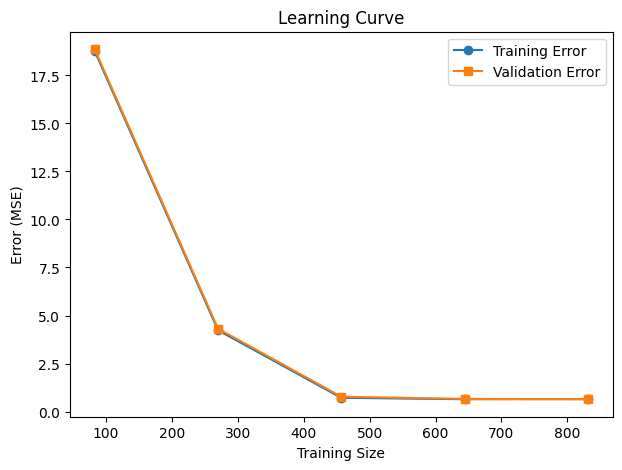

In [40]:
train_sizes, train_scores, test_scores = learning_curve(best_model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_mean, label="Training Error", marker="o")
plt.plot(train_sizes, test_mean, label="Validation Error", marker="s")
plt.xlabel("Training Size")
plt.ylabel("Error (MSE)")
plt.legend()
plt.title("Learning Curve")
plt.show()

C:\Users\Robyi\AppData\Local\Temp\ipykernel_15220\228558249.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")


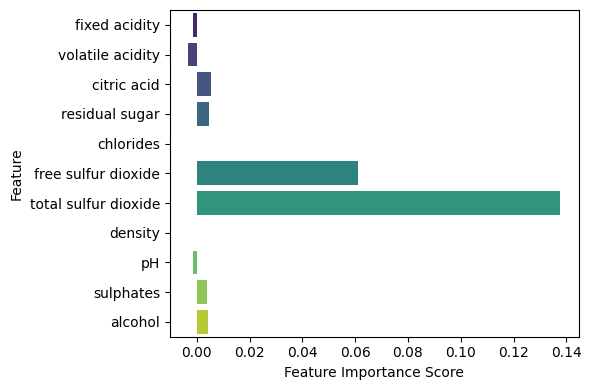

In [42]:
perm_importance = permutation_importance(best_model, x_test, y_test, scoring="neg_mean_squared_error")
feature_importance = perm_importance.importances_mean

feature_names = x_train.columns

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [43]:
explainer = shap.Explainer(best_model.predict, x_train)
shap_values = explainer(x_test)

PermutationExplainer explainer: 561it [01:54,  4.89it/s]                         


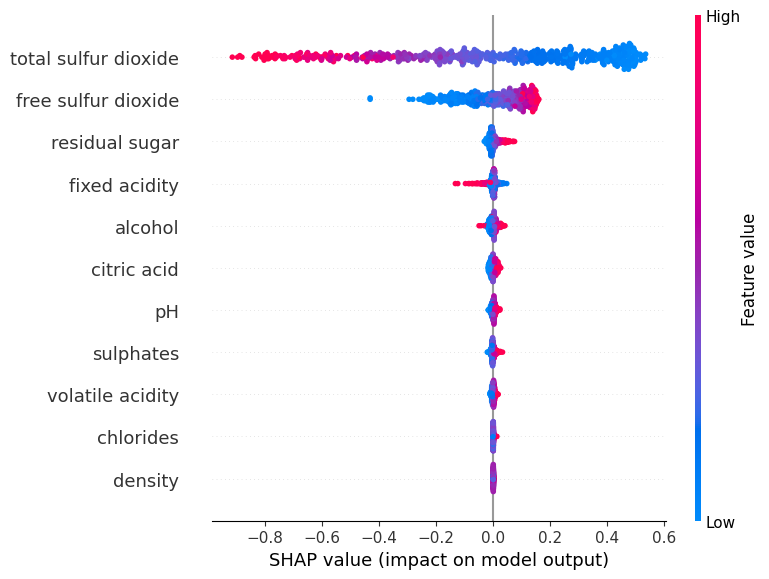

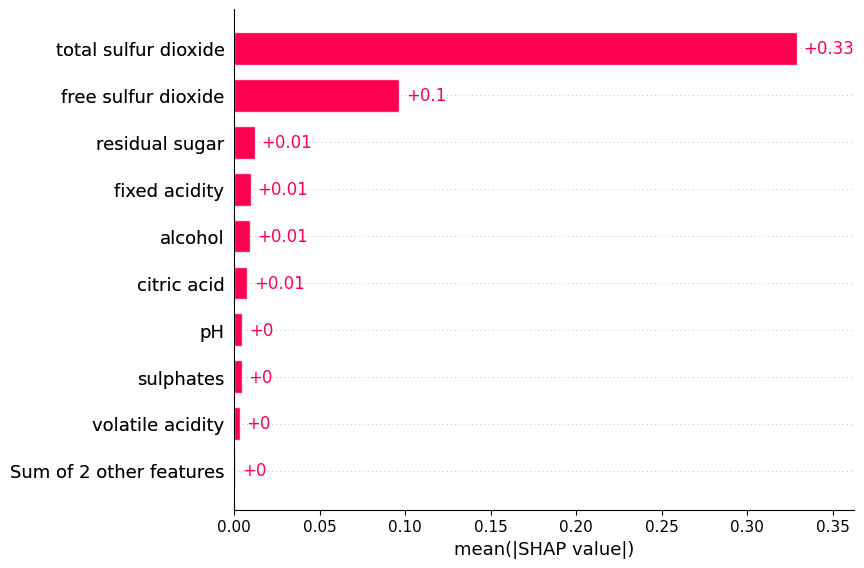

In [44]:
shap.summary_plot(shap_values, x_test, feature_names=x_train.columns)
shap.plots.bar(shap_values)